- using peft from finetune generative models 
- using hugging face 'polite' dataset 
- using pytorch lightning from comfortable coding 

# Initalize paramaters & Import libs 

In [1]:
class Config:
    tok_params = {'return_tensors': 'pt', 
                  'padding': 'max_length', 
                  'truncation': True}
    batch_size = 16
    num_epoch = 1 
    
    def __init__(self):
#     Discriminator 
        self.dmodel_preset = 'distilbert/distilbert-base-uncased'
        self.dnum_labels = 10  # Adjust according to your classification task
#     Generator 
        self.gmodel_preset = 'describeai/gemini-small'
        self.generator_max_length = 256
#     Dataset
        self.dataset = 'jdustinwind/Polite'    
        self.rude, self.polite = ['src', 'tgt']
    
cfg = Config()

In [2]:
# ! python -m pip install -q lightning
! pip install -q datasets==2.18.0 rouge_score

import datasets as ds  
import transformers as tr

ds.__version__, tr.__version__

('2.18.0', '4.39.3')

In [3]:
# COMING SOON
# ..........
# # comfortable model training and coding 
# import lightning as L 
# ..........

# neural network 
import torch
from torch import nn 
import torch.optim as optim
# load and use models 
from transformers import AutoModelForSeq2SeqLM, AutoModel, AutoTokenizer

# work with data
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import datasets 

import nltk
nltk.download('punkt')

from tqdm import tqdm

metric = datasets.load_metric('rouge')

device = torch.device('cuda' if torch.cuda.is_available() == True else 'cpu')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/tmp/ipykernel_24/154309560.py:24: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric('rouge')
/opt/conda/lib/python3.10/site-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


# Data Preprocess & Build Generator and Discriminator model & Build GAN

In [4]:
def tokenize_batch(rude, polite, gen_tokenizer, dics_tokenizer): 
    params = cfg.tok_params
    
    gen_tokens_rude = gen_tokenizer(rude, **params)
    gen_tokens_polite = gen_tokenizer(polite, **params)
    
    disc_tokens_polite = disc_tokenizer(polite, **params)
    
    return {
#         FOR GENERATOR
        "rude_input_ids_g": gen_tokens_rude['input_ids'].squeeze(), 
        "rude_attention_mask_g": gen_tokens_rude['attention_mask'].squeeze(), 
        
        "polite_input_ids_g": gen_tokens_polite['input_ids'].squeeze(), 
        "polite_attention_mask_g": gen_tokens_polite['attention_mask'].squeeze(), 
#         FOR DISCRIMINATOR 
        "d_polite_input_ids": disc_tokens_polite['input_ids'].squeeze(), 
        "d_polite_attention_mask": disc_tokens_polite['attention_mask'].squeeze(), 
    }


In [5]:
class Generator(nn.Module): 
    def __init__(self, text2text_preset): 
        super().__init__()
        
        self.gen = AutoModelForSeq2SeqLM.from_pretrained(text2text_preset)
        
    def forward(self, **input_batch): 
        return self.gen.generate(**input_batch, max_length = cfg.generator_max_length)
    
class Discriminator(nn.Module):
    def __init__(self, model_preset, dropout = 0.3): 
        super().__init__()
        
        self.backbone = AutoModel.from_pretrained(model_preset)

        self.dropout = nn.Dropout(dropout)
        self.lin = nn.Linear(self.backbone.config.dim, cfg.dnum_labels)
        self.softmax=  nn.Softmax(dim=-1)
        
    def forward(self, **input_batch):
        backbone_output = self.backbone(**input_batch).last_hidden_state[:, 0, :]
        
        drop_output = self.dropout(backbone_output)
        output = self.lin(drop_output)
        return self.softmax(output)

In [6]:
import numpy as np

def compute_metrics(eval_pred, tokenizer):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip()))
                      for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) 
                      for label in decoded_labels]
    
    # Compute ROUGE scores
    result = metric.compute(predictions=decoded_preds, references=decoded_labels,
                            use_stemmer=True)

    # Extract ROUGE f1 scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length to metrics
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id)
                      for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

In [7]:
class GAN(): 
    def __init__(self, 
#                  DISCRIMINATOR
                 discriminator, 
                 discriminator_tokenizer, 
                 
                 
#                  GENERATOR
                 generator, 
                 generator_tokenizer, 
                 
                 discriminator_lr = 1e-4, 
                 generator_lr = 1e-4, 
                ): 
        
        self.d = discriminator.to(device)
        self.g = generator.to(device)
        
        self.dt = discriminator_tokenizer
        self.gt = generator_tokenizer
        
        self.do = optim.AdamW(discriminator.parameters(), lr=discriminator_lr)
        self.go = optim.AdamW(generator.parameters(), lr=generator_lr)
        
        self.criterion = nn.BCELoss()
        
    def train_step(self, batch): 
        batch = {k: v.to(device) for (k, v) in batch.items()}
        
        # -----------------
        #  Train Generator
        # -----------------
        
        self.go.zero_grad()
        
        polite_ids = self.g(input_ids = batch['rude_input_ids_g'], attention_mask = batch['rude_attention_mask_g'])

        polite_gen = self.gt.batch_decode(polite_ids)
        polite_gen = self.dt(polite_gen, **cfg.tok_params).to(device)
        
        dics_polite_gen = self.d(**polite_gen)
        
#         fake (0) -> real (1)
        g_loss = self.criterion(dics_polite_gen, torch.ones(dics_polite_gen.shape).to(device))
        g_loss.backward()
        self.go.step()
        
        
        # -----------------
        #  Train Discriminator
        # -----------------
        
        self.do.zero_grad() 
        
        dics_polite_fake = self.d(**polite_gen)
        dics_polite_real = self.d(input_ids = batch['d_polite_input_ids'], attention_mask = batch['d_polite_attention_mask'])
        
#         fake (...) -> 0
        fake_loss = self.criterion(dics_polite_fake, torch.zeros(dics_polite_fake.shape).to(device)) 
#         real (..) -> 1
        real_loss = self.criterion(dics_polite_real, torch.ones(dics_polite_real.shape).to(device))
        
        fake_loss.backward()
        real_loss.backward() 
        self.do.step() 
        
        return {'generator_loss': g_loss.cpu().detach().numpy(), 'discriminator_loss': (fake_loss + real_loss).cpu().detach().numpy()}
    
    def validation_step(self, batch):
        batch = {k: v.to(device) for (k, v) in batch.items()}
#         METRICKS FOR GENERATOR 
        labels = batch['polite_input_ids_g']
        pred = self.g(input_ids = batch['rude_input_ids_g'], attention_mask = batch['rude_attention_mask_g'])

        generator_m = compute_metrics((labels.cpu(), pred.cpu()), tokenizer = self.gt)
#         METRICKS FOR DISCRIMINATOR
        return generator_m

# Load model & dataset from hub

In [8]:
generator = Generator(cfg.gmodel_preset)
gen_tokenizer = AutoTokenizer.from_pretrained(cfg.gmodel_preset) 

discriminator = Discriminator(cfg.dmodel_preset)
disc_tokenizer = AutoTokenizer.from_pretrained(cfg.dmodel_preset) 

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
gan = GAN(generator = generator, 
          generator_tokenizer=gen_tokenizer, 
          
          discriminator = discriminator, 
          discriminator_tokenizer = disc_tokenizer)

In [10]:
ds = datasets.load_dataset(cfg.dataset)
ds = ds['train'].to_pandas()

ds_train, ds_test = train_test_split(ds, test_size = 0.1)

Repo card metadata block was not found. Setting CardData to empty.


Generating train split: 0 examples [00:00, ? examples/s]

In [11]:
class MyDataset(Dataset): 
    def __init__(self, polites, rudes, generator_tokenizer, discriminator_tokenizer): 
        super().__init__()
        
        self.gt=  generator_tokenizer
        self.dt = discriminator_tokenizer 
        
        self.polites = polites
        self.rudes = rudes 
        
    def __getitem__(self, idx): 
        return tokenize_batch(self.rudes[idx], self.polites[idx], self.gt, self.dt)
    
    def __len__(self,): 
        return len(self.polites)
    
def build_tensor_ds(dataframe): 
    
    dataset = MyDataset(polites = dataframe[cfg.polite].to_list(), 
                        rudes = dataframe[cfg.rude].to_list(), 
        
                        generator_tokenizer = gen_tokenizer, 
                        discriminator_tokenizer = disc_tokenizer)

    return DataLoader(dataset, batch_size = cfg.batch_size, shuffle=True)
    
dl_train = build_tensor_ds(ds_train)
dl_valid = build_tensor_ds(ds_test)

# Run Train 

In [12]:
generator.train()
discriminator.train() 

train_logs = list() 
validation_logs = list() 
for epoch in range(cfg.num_epoch): 
    print(f"{epoch}/{cfg.num_epoch}")
    
    for batch in tqdm(dl_train, desc = 'Train...'):
        log = gan.train_step(batch)
        train_logs.append(log)
        
    for batch in tqdm(dl_valid, desc = 'Validation...'): 
        log = gan.validation_step(batch)
        validation_logs.append(log)

0/1


Validation...: 100%|██████████| 625/625 [17:29<00:00,  1.68s/it]


In [13]:
torch.save({
    'generator': generator.state_dict(), 
    'discriminator': discriminator.state_dict(), 
    'train_logs': train_logs, 
    'validation_logs': validation_logs}, 
    f = 'checkpoint'
)

# Visualize Logs 

In [14]:
import matplotlib.pyplot as plt

def plot_training_losses(train_losses, title="Training Loss", xlabel="Step", ylabel="Loss"):
    """
    Function to visualize the training losses.

    Parameters:
    - train_losses: List of training losses (list of floats).
    - title: Title of the plot (default: "Training Loss").
    - xlabel: Label for the x-axis (default: "Epoch").
    - ylabel: Label for the y-axis (default: "Loss").
    """
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, marker='o', linestyle='-', color='b', label='Training Loss')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# example_losses = [2.3, 2.1, 1.9, 1.7, 1.5, 1.3, 1.1, 0.9, 0.8]
# plot_training_losses(example_losses)

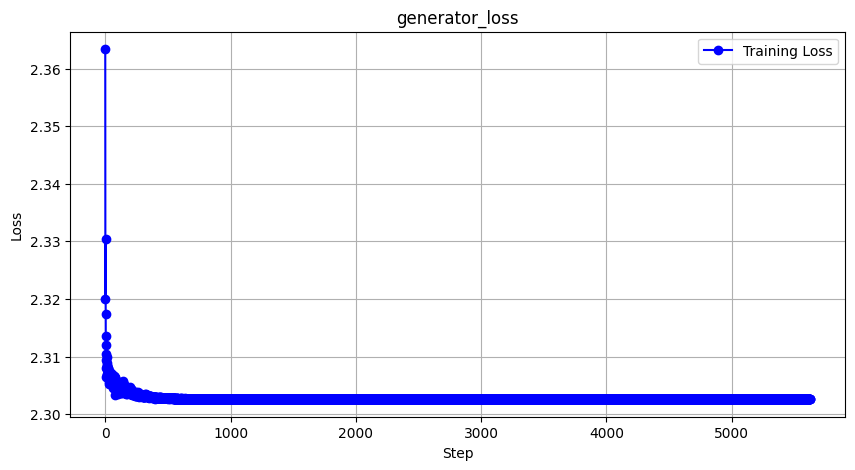

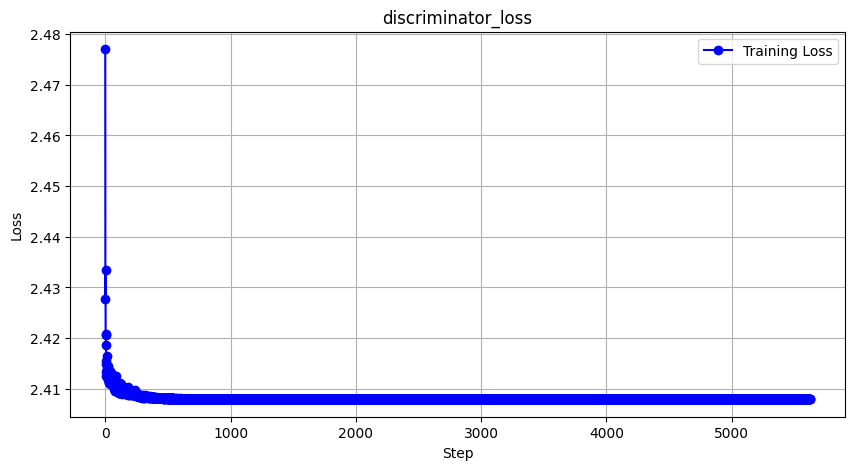

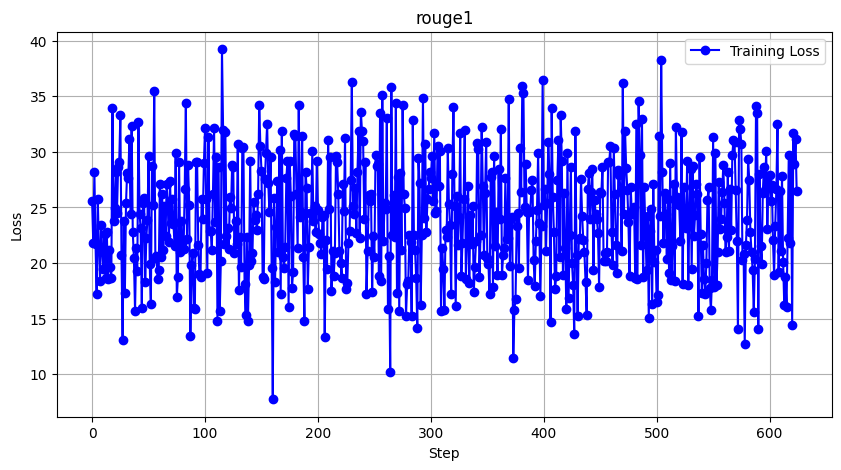

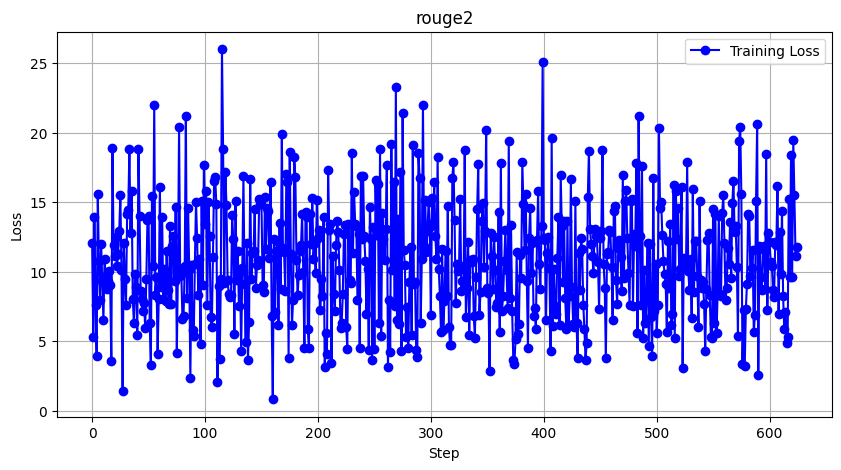

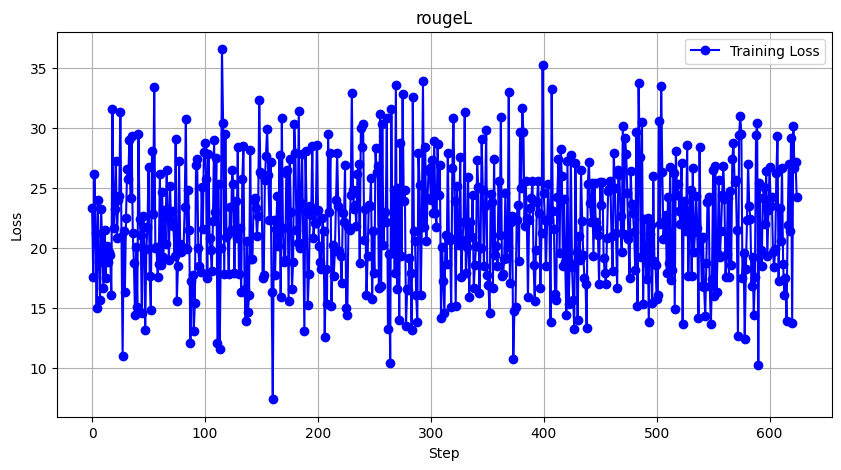

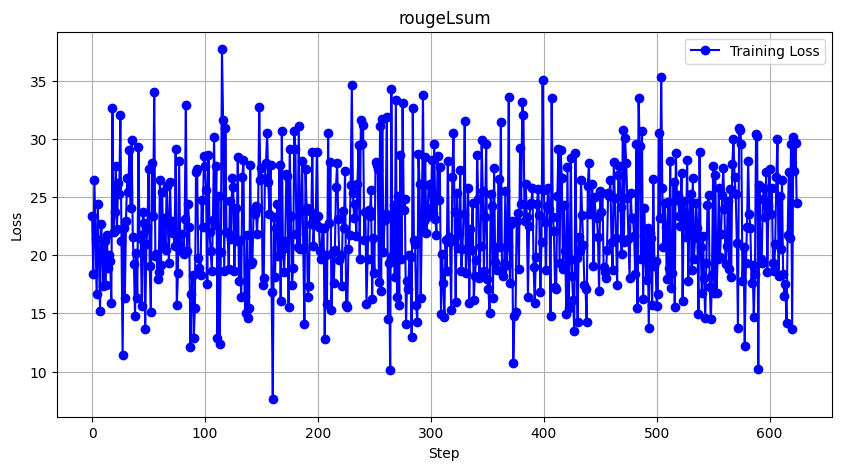

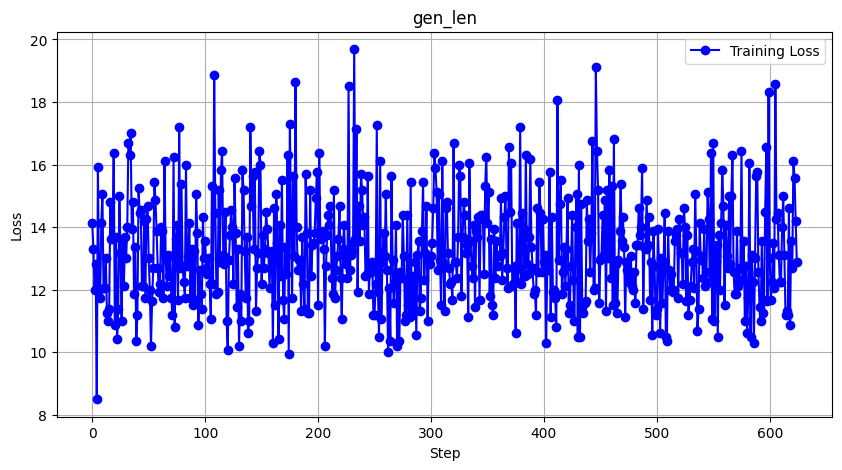

In [15]:
# TRAIN 
for k, _ in train_logs[0].items(): 
    history = [i[k] for i in train_logs]
    plot_training_losses(history, title = k)
    
# VALIDATION 
for k, _ in validation_logs[0].items(): 
    history = [i[k] for i in validation_logs]
    plot_training_losses(history, title = k)